In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import models,layers

In [2]:
dftrain_raw = pd.read_csv('./data/titanic/train.csv')
dftest_raw = pd.read_csv('./data/titanic/test.csv')
dftrain_raw.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,493,0,1,"Molson, Mr. Harry Markland",male,55.0,0,0,113787,30.5000,C30,S
1,53,1,1,"Harper, Mrs. Henry Sleeper (Myna Haxtun)",female,49.0,1,0,PC 17572,76.7292,D33,C
2,388,1,2,"Buss, Miss. Kate",female,36.0,0,0,27849,13.0000,NaN,S
3,192,0,2,"Carbines, Mr. William",male,19.0,0,0,28424,13.0000,NaN,S
4,687,0,3,"Panula, Mr. Jaako Arnold",male,14.0,4,1,3101295,39.6875,NaN,S
5,16,1,2,"Hewlett, Mrs. (Mary D Kingcome)",female,55.0,0,0,248706,16.0000,NaN,S
6,228,0,3,"Lovell, Mr. John Hall (""Henry"")",male,20.5,0,0,A/5 21173,7.2500,NaN,S
7,884,0,2,"Banfield, Mr. Frederick James",male,28.0,0,0,C.A./SOTON 34068,10.5000,NaN,S
8,168,0,3,"Skoog, Mrs. William (Anna Bernhardina Karlsson)",female,45.0,1,4,347088,27.9000,NaN,S
9,752,1,3,"Moor, Master. Meier",male,6.0,0,1,392096,12.4750,E121,S


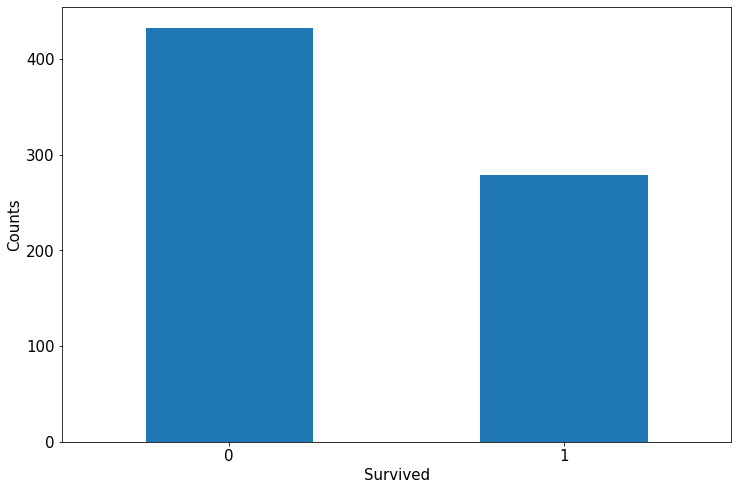

In [3]:
%matplotlib inline
%config InlineBackend.fingure_font = 'png'
ax = dftrain_raw['Survived'].value_counts().plot(kind = 'bar',
     figsize = (12,8),fontsize=15,rot = 0)
ax.set_ylabel('Counts',fontsize = 15)
ax.set_xlabel('Survived',fontsize = 15)
plt.show()

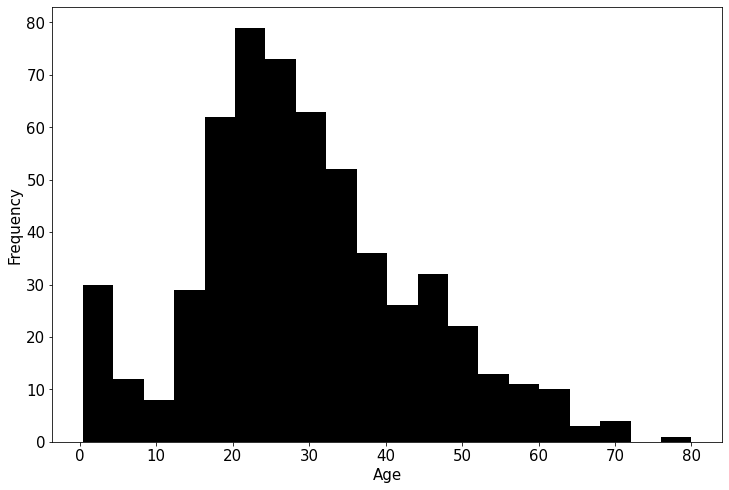

In [4]:
ax = dftrain_raw['Age'].plot(kind = 'hist', bins = 20, color = 'black',
                            figsize = (12, 8), fontsize = 15)
ax.set_xlabel('Age', fontsize = 15)
ax.set_ylabel('Frequency', fontsize = 15)
plt.show()

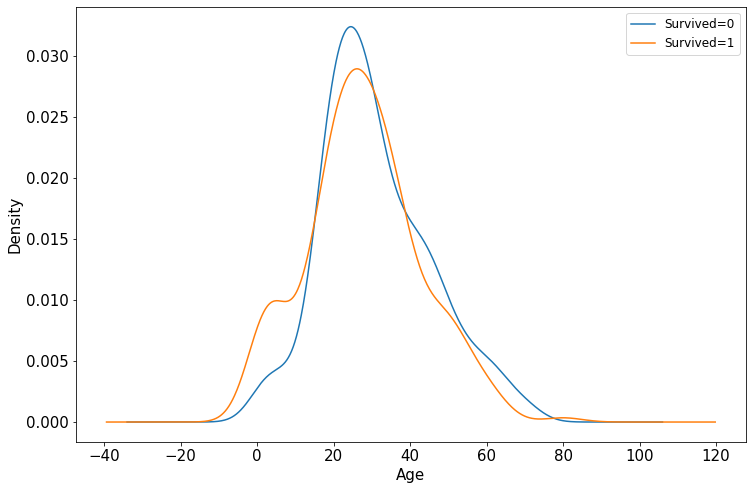

In [5]:
ax = dftrain_raw.query('Survived == 0')['Age'].plot(kind = 'density', figsize = (12,8), fontsize=15)
dftrain_raw.query('Survived == 1')['Age'].plot(kind='density', figsize=(12, 8), fontsize=15)
ax.legend(['Survived=0', 'Survived=1'], fontsize=12)
ax.set_xlabel('Age', fontsize=15)
ax.set_ylabel('Density', fontsize=15)
plt.show()

In [6]:
#数据预处理

def preprocessing(dfdata):
    dfresult = pd.DataFrame()
    
    #Pclass
    dfPclass = pd.get_dummies(dfdata['Pclass']) #将原始数据中的序列变成DataFrame的形式
    dfPclass.columns = ['Pclass_' +str(x) for x in dfPclass.columns] #设定相应的列名字
    dfresult = pd.concat([dfresult, dfPclass], axis=1) #将dfClass水平并入dfresult中，原来的dfresult是空内容
    
    #Sex
    #对Sex列做同样的处理
    dfSex = pd.get_dummies(dfdata['Sex'])
    dfresult = pd.concat([dfresult, dfSex], axis=1)
    
    #Embarked
    dfEmbarked = pd.get_dummies(dfdata['Embarked'], dummy_na=True) #在DataFrame结构中加入NaN一列，将未知上船地点的数据提取出来
    dfEmbarked.columns = ['Embarked_' +str(x) for x in dfEmbarked.columns]
    dfresult = pd.concat([dfresult, dfEmbarked], axis=1)
    
    
    #Age
    dfresult['Age'] = dfdata['Age'].fillna(0) #将未知年龄的位置用0填充
    dfresult['Age_null'] = pd.isna(dfdata['Age']).astype('int32') #在列'Age_null'中，将没有年龄的位置用1填充，有年龄的位置为0
    #Carbin
    dfresult['Cabin_null'] = pd.isna(dfdata['Cabin']).astype('int32') #同上，创建新列'Carbin_null'，其中没有名字为1，有名字为0
    
    #Sibsp, Parch, Fare
    dfresult['SibSp'] = dfdata['SibSp']
    dfresult['Parch'] = dfdata['Parch']
    dfresult['Fare'] = dfdata['Fare'] #将不那么重要的数据直接加入dfreslut中
    
    return dfresult

In [7]:
x_train = preprocessing(dftrain_raw)
y_train = dftrain_raw['Survived'].values

x_test = preprocessing(dftest_raw)
y_test = dftest_raw['Survived'].values

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(712, 15)
(712,)
(179, 15)
(179,)


In [8]:
tf.keras.backend.clear_session()

model = tf.keras.Sequential()
model.add(layers.Dense(20, activation='relu', input_shape=(15,)))
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 20)                320       
_________________________________________________________________
dense_1 (Dense)              (None, 10)                210       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 541
Trainable params: 541
Non-trainable params: 0
_________________________________________________________________


In [9]:
#选择最简单的fit内置函数训练，优化方法为Adam，AUC用来评判优化程度
model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['AUC'])

history = model.fit(x_train, y_train,
                   batch_size= 64,
                   epochs= 30,
                   validation_split= 0.2)
#分割一部分训练数据用于验证

Epoch 1/30
9/9 [==============================] - 1s 57ms/step - loss: 2.0026 - auc: 0.5379 - val_loss: 1.9686 - val_auc: 0.5429
Epoch 2/30
9/9 [==============================] - 0s 3ms/step - loss: 1.5238 - auc: 0.5401 - val_loss: 1.4919 - val_auc: 0.5557
Epoch 3/30
9/9 [==============================] - 0s 3ms/step - loss: 1.1459 - auc: 0.5484 - val_loss: 1.1325 - val_auc: 0.5624
Epoch 4/30
9/9 [==============================] - 0s 3ms/step - loss: 0.9646 - auc: 0.5182 - val_loss: 0.8541 - val_auc: 0.5631
Epoch 5/30
9/9 [==============================] - 0s 3ms/step - loss: 0.8320 - auc: 0.4907 - val_loss: 0.7235 - val_auc: 0.5789
Epoch 6/30
9/9 [==============================] - 0s 3ms/step - loss: 0.7675 - auc: 0.5244 - val_loss: 0.6626 - val_auc: 0.6365
Epoch 7/30
9/9 [==============================] - 0s 3ms/step - loss: 0.7034 - auc: 0.5586 - val_loss: 0.6224 - val_auc: 0.6704
Epoch 8/30
9/9 [==============================] - 0s 4ms/step - loss: 0.6590 - auc: 0.6080 - val_loss: 

In [10]:
def plot_metric(history, metric):
    train_metrics = history.history[metric]
    val_metrics = history.history['val_'+metric]
    epochs = range(1, len(train_metrics)+1)
    plt.plot(epochs, train_metrics, 'bo--')
    plt.plot(epochs, val_metrics, 'ro-')
    plt.title('Training and Validation '+ metric)
    plt.xlabel('Epochs')
    plt.ylabel(metric)
    plt.legend(['train_'+metric, 'Val_'+metric])
    plt.show()

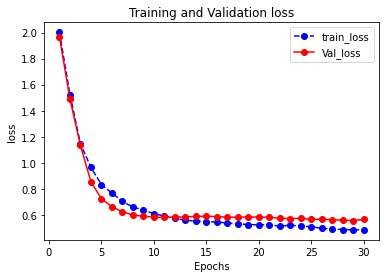

In [12]:
plot_metric(history, 'loss')

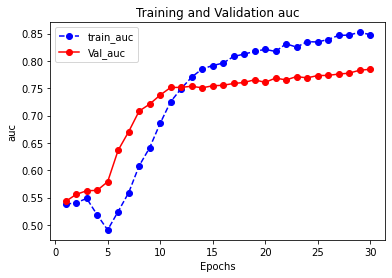

In [13]:
plot_metric(history, 'auc')

In [14]:
#模型在测试集上的效果
model.evaluate(x = x_test, y = y_test)

6/6 [==============================] - 0s 1ms/step - loss: 0.5012 - auc: 0.8292


[0.5012316703796387, 0.8292282223701477]

In [15]:
#预测概率
model.predict(x_test[0:10])

array([[0.0804441 ],
       [0.4472255 ],
       [0.39659804],
       [0.70340335],
       [0.43301842],
       [0.46348137],
       [0.07724178],
       [0.7248857 ],
       [0.6412253 ],
       [0.13294175]], dtype=float32)

In [16]:
#预测类别
model.predict_classes(x_test[0:10])

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


array([[0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0]])

In [17]:
(model.predict(x_test[0:10]) > 0.5).astype('int32')

array([[0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0]])

In [18]:
#保存模型结构及权重
model.save('./data/titanic/titanic_model.h5')

del model #删除现有模型

model = models.load_model('./data/titanic/titanic_model.h5')
model.evaluate(x_test, y_test)


6/6 [==============================] - 0s 1ms/step - loss: 0.5012 - auc: 0.8292


[0.5012316703796387, 0.8292282223701477]

In [19]:
#保存模型结构
json_str = model.to_json()

#保存模型参数
model.save_weights('./data/titanic/titanic_model_weight.h5')

#恢复模型结构
model_json = models.model_from_json(json_str)
model_json.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['AUC'])

#恢复模型参数
model_json.load_weights('./data/titanic/titanic_model_weight.h5')
model_json.evaluate(x_test, y_test)


6/6 [==============================] - 0s 2ms/step - loss: 0.5012 - auc: 0.8292


[0.5012316703796387, 0.8292282223701477]

In [23]:
#tensorflow原生态保存数据
#保存权重张量
model.save_weights('./data/titanic/titanic_model_weights_tf.ckpt', save_format='tf')

#保存模型结构与模型参数
model.save('./data/titanic/titanic_savedmodel_tf', save_format='tf')
print('Export saved model')

model_loaded = tf.keras.models.load_model('./data/titanic/titanic_savedmodel_tf')
model_loaded.evaluate(x_test, y_test)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ./data/titanic/titanic_savedmodel_tf\assets
Export saved model
6/6 [==============================] - 0s 3ms/step - loss: 0.5012 - auc: 0.8292


[0.5012316703796387, 0.8292282223701477]